In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
import powerbox as pbox
import torch

from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.lenses import SIE, KappaGrid, PseudoJaffe
from caustic.sources import Sersic
from caustic.utils import get_meshgrid

## SIE, pseudo-Jaffe and Gaussian random field checks

In [3]:
n_pix = 128
fov = 25.0
res = fov / n_pix

In [4]:
z_l = torch.tensor(0.5)
z_s = torch.tensor(1.2)
cosmology = FlatLambdaCDMCosmology("cosmo")
upsample_factor = 4
thx_fine, thy_fine = get_meshgrid(
    res / upsample_factor, upsample_factor * n_pix, upsample_factor * n_pix
)
thx, thy = get_meshgrid(res, n_pix, n_pix)


# Fix kappa map Param
kappa_fft = KappaGrid(
    "kg-fft", fov, n_pix, cosmology, z_l, kappa_map_shape=(1, 1, 128, 128), mode="fft"
)
kappa_conv2d = KappaGrid(
    "kg-conv2d",
    fov,
    n_pix,
    cosmology,
    z_l,
    kappa_map_shape=(1, 1, 128, 128),
    mode="conv2d",
)

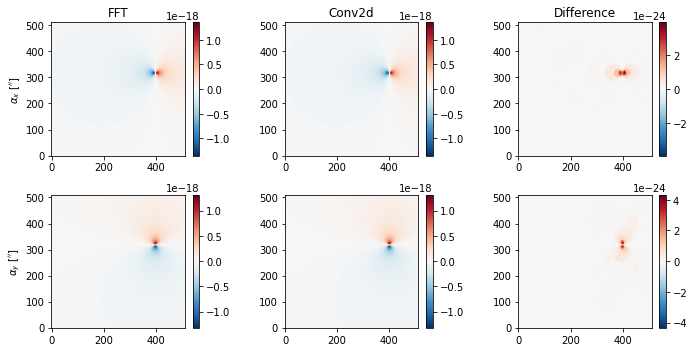

In [6]:
pj = PseudoJaffe("pj", cosmology, z_l)
thx0 = 7.0
thy0 = 3.0
th_core = 0.04
th_s = 0.2
rho_0 = 1.0
kappa_0 = pj.kappa_0(z_l, z_s, rho_0, th_core, th_s, cosmology)
# z_l, thx0, thy0, kappa_0, th_core, th_s
x_pj = torch.tensor([thx0, thy0, kappa_0, th_core, th_s])

kappa_pj = pj.kappa(thx, thy, z_s, pj.x_to_dict(x_pj))[None, None]
ax_fft, ay_fft = kappa_fft.alpha(
    thx_fine, thy_fine, z_s, kappa_fft.x_to_dict([kappa_pj])
)
ax_conv2d, ay_conv2d = kappa_conv2d.alpha(
    thx_fine, thy_fine, z_s, kappa_conv2d.x_to_dict([kappa_pj])
)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for a_fft, a_c2d, axs in zip(
    (ax_fft, ay_fft),
    (ax_conv2d, ay_conv2d),
    axes
):
    ax = axs[0]
    im = ax.imshow(a_fft[0, 0], cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axs[1]
    im = ax.imshow(a_c2d[0, 0], cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axs[2]
    im = ax.imshow((a_fft - a_c2d)[0, 0], cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

axes[0, 0].set_title("FFT")
axes[0, 1].set_title("Conv2d")
axes[0, 2].set_title("Difference")
axes[0, 0].set_ylabel(r"$\alpha_x$ [$''$]")
axes[1, 0].set_ylabel(r"$\alpha_y$ [$''$]")

fig.tight_layout()

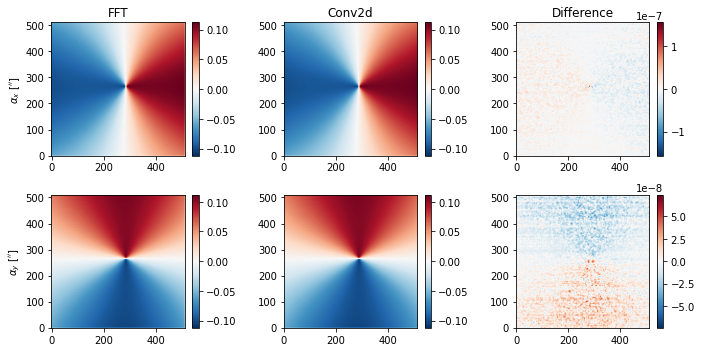

In [7]:
sie = SIE(
    "sie",
    cosmology,
    z_l,
    thx0=torch.tensor(1.5),
    thy0=torch.tensor(0.5),
    q=torch.tensor(0.99),
    phi=torch.tensor(0.0),
    b=torch.tensor(0.1),
)
kappa_sie = sie.kappa(thx, thy, z_s)[None, None]
ax_fft, ay_fft = kappa_fft.alpha(
    thx_fine, thy_fine, z_s, kappa_fft.x_to_dict([kappa_sie])
)
ax_conv2d, ay_conv2d = kappa_conv2d.alpha(
    thx_fine, thy_fine, z_s, kappa_conv2d.x_to_dict([kappa_sie])
)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for a_fft, a_c2d, axs in zip((ax_fft, ay_fft), (ax_conv2d, ay_conv2d), axes):
    ax = axs[0]
    im = ax.imshow(a_fft[0, 0], cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axs[1]
    im = ax.imshow(a_c2d[0, 0], cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axs[2]
    im = ax.imshow((a_fft - a_c2d)[0, 0], cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

axes[0, 0].set_title("FFT")
axes[0, 1].set_title("Conv2d")
axes[0, 2].set_title("Difference")
axes[0, 0].set_ylabel(r"$\alpha_x$ [$''$]")
axes[1, 0].set_ylabel(r"$\alpha_y$ [$''$]")

fig.tight_layout()

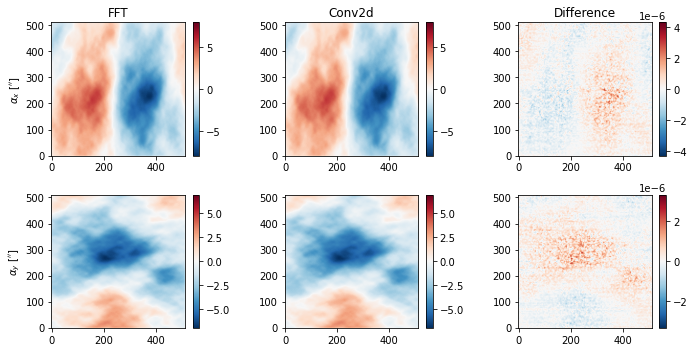

In [8]:
# Gaussian random field
kappa_m = torch.as_tensor(pbox.PowerBox(
    N=n_pix,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: k**-2, # The power-spectrum
    boxlength = 0.01,           # Size of the box (sets the units of k in pk)
).delta_x(), dtype=torch.float32)[None, None]

ax_fft, ay_fft = kappa_fft.alpha(
    thx_fine, thy_fine, z_s, kappa_fft.x_to_dict([kappa_m])
)
ax_conv2d, ay_conv2d = kappa_conv2d.alpha(
    thx_fine, thy_fine, z_s, kappa_conv2d.x_to_dict([kappa_m])
)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for a_fft, a_c2d, axs in zip((ax_fft, ay_fft), (ax_conv2d, ay_conv2d), axes):
    ax = axs[0]
    im = ax.imshow(a_fft[0, 0], cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axs[1]
    im = ax.imshow(a_c2d[0, 0], cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axs[2]
    im = ax.imshow((a_fft - a_c2d)[0, 0], cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

axes[0, 0].set_title("FFT")
axes[0, 1].set_title("Conv2d")
axes[0, 2].set_title("Difference")
axes[0, 0].set_ylabel(r"$\alpha_x$ [$''$]")
axes[1, 0].set_ylabel(r"$\alpha_y$ [$''$]")

fig.tight_layout()

## Rigorous pseudo-Jaffe test

In [9]:
def _setup(n_pix=1000, mode="fft", use_next_fast_len=True):
    fov = 25.0
    res = fov / n_pix
    thx, thy = get_meshgrid(res, n_pix, n_pix)

    z_l = torch.tensor(0.5)
    z_s = torch.tensor(2.1)

    cosmology = FlatLambdaCDMCosmology("cosmology")
    # Use PseudoJaffe since it is compact: 99.16% of its mass is contained in
    # the circle circumscribing this image plane
    lens_pj = PseudoJaffe("pj", cosmology)

    thx0 = 7.0
    thy0 = 3.0
    th_core = 0.04
    th_s = 0.2
    rho_0 = 1.0
    kappa_0 = lens_pj.kappa_0(z_l, z_s, rho_0, th_core, th_s, cosmology)
    # z_l, thx0, thy0, kappa_0, th_core, th_s
    x_pj = torch.tensor([z_l, thx0, thy0, kappa_0, th_core, th_s])

    # Exact calculations
    Psi = lens_pj.Psi(thx, thy, z_l, lens_pj.x_to_dict(x_pj))
    Psi -= Psi.min()
    alpha_x, alpha_y = lens_pj.alpha(thx, thy, z_l, lens_pj.x_to_dict(x_pj))

    # Approximate calculations
    lens_kap = KappaGrid(
        "kg",
        fov,
        n_pix,
        cosmology,
        z_l=z_l,
        kappa_map_shape=(1, 1, n_pix, n_pix),
        mode=mode,
        use_next_fast_len=use_next_fast_len,
    )
    kappa_map = lens_pj.kappa(thx, thy, z_l, lens_pj.x_to_dict(x_pj))
    x_kap = kappa_map.flatten()

    Psi_approx = lens_kap.Psi(thx, thy, z_l, lens_kap.x_to_dict(x_kap))
    Psi_approx = Psi_approx[0, 0]
    Psi_approx -= Psi_approx.min()
    # Try to remove unobservable constant offset
    Psi_approx += torch.mean(Psi - Psi_approx)

    alpha_x_approx, alpha_y_approx = lens_kap.alpha(
        thx, thy, z_l, lens_kap.x_to_dict(x_kap)
    )
    alpha_x_approx = alpha_x_approx[0, 0]
    alpha_y_approx = alpha_y_approx[0, 0]

    return Psi, Psi_approx, alpha_x, alpha_x_approx, alpha_y, alpha_y_approx

In [10]:
Psi, Psi_approx, alpha_x, alpha_x_approx, alpha_y, alpha_y_approx = _setup()

In [11]:
def _check_center(x, x_approx, center_c, center_r, rtol=1e-5, atol=1e-8, half_buffer=20):
    idx_before_r = center_r - half_buffer
    idx_after_r = center_r + half_buffer
    idx_before_c = center_c - half_buffer
    idx_after_c = center_c + half_buffer
    assert torch.allclose(x[:idx_before_r], x_approx[:idx_before_r], rtol, atol)
    assert torch.allclose(x[idx_after_r:], x_approx[idx_after_r:], rtol, atol)
    assert torch.allclose(
        x[idx_before_r:idx_after_r, :idx_before_c],
        x_approx[idx_before_r:idx_after_r, :idx_before_c],
        rtol,
        atol,
    )
    assert torch.allclose(
        x[idx_before_r:idx_after_r, idx_after_c:],
        x_approx[idx_before_r:idx_after_r, idx_after_c:],
        rtol,
        atol,
    )


In [12]:
_check_center(Psi, Psi_approx, 780, 620, atol=1e-20)
_check_center(alpha_x, alpha_x_approx, 780, 620, atol=1e-20)
_check_center(alpha_y, alpha_y_approx, 780, 620, atol=1e-20)

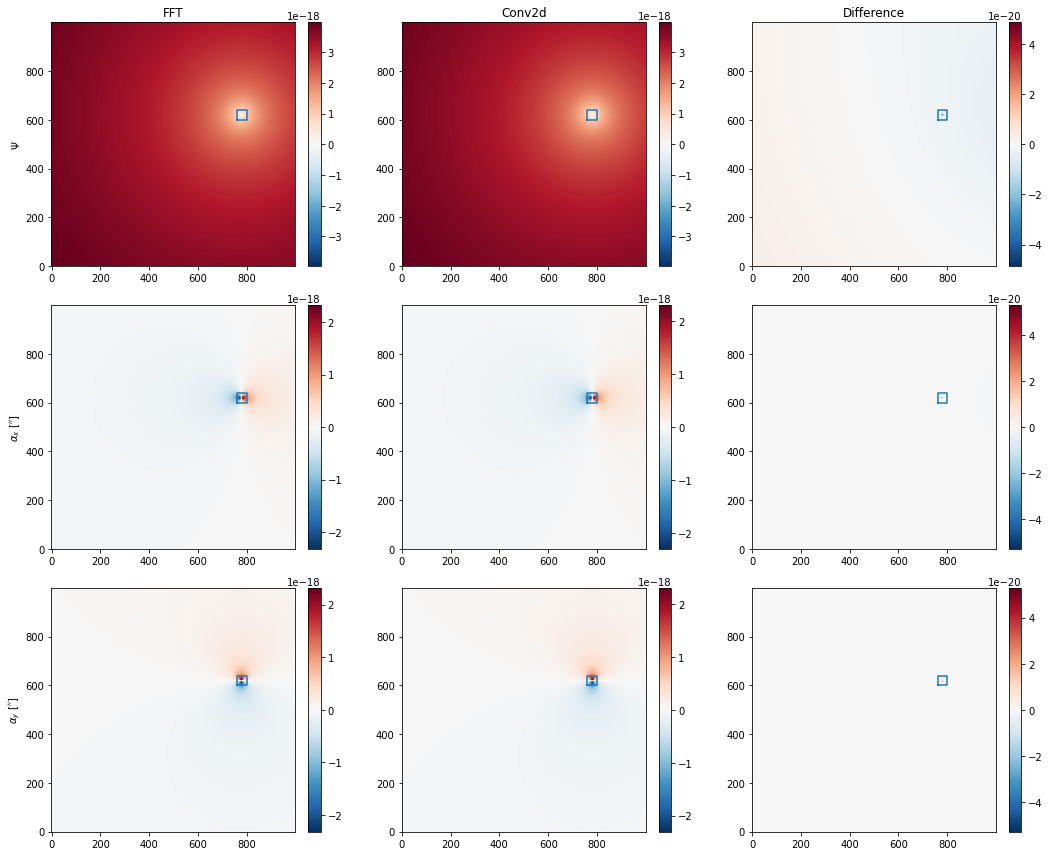

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

center_x = 780
center_y = 620
half = 20

for a, a_approx, axs in zip(
    (Psi, alpha_x, alpha_y), (Psi_approx, alpha_x_approx, alpha_y_approx), axes
):
    ax = axs[0]
    im = ax.imshow(a, cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axs[1]
    im = ax.imshow(a_approx, cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axs[2]
    im = ax.imshow((a - a_approx), cmap="RdBu_r", norm=CenteredNorm(), origin="lower")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

axes[0, 0].set_title("FFT")
axes[0, 1].set_title("Conv2d")
axes[0, 2].set_title("Difference")
axes[0, 0].set_ylabel(r"$\Psi$")
axes[1, 0].set_ylabel(r"$\alpha_x$ [$''$]")
axes[2, 0].set_ylabel(r"$\alpha_y$ [$''$]")

for ax in axes.flatten():
    ax.plot(
        [
            center_x - half,
            center_x + half,
            center_x + half,
            center_x - half,
            center_x - half,
        ],
        [
            center_y - half,
            center_y - half,
            center_y + half,
            center_y + half,
            center_y - half,
        ],
    )

fig.tight_layout()